## Recurrent Neural Network


Clasificacion de FakeNews de si son reales o falsas

Dataset:

https://www.kaggle.com/c/fake-news/overview

Se esta trabajando con todo el dataset, en la parte incial realizando una tokenizacion del texto, posteriormente se realiza el modelo utilizando word2vec preentrenado de una base de datos de GoogleNews

https://code.google.com/archive/p/word2vec/   (The model contains 300-dimensional vectors for 3 million words and phrases), con un peso de mas de 3.3Gb en disco



In [68]:
import os
import numpy as np
import pandas as pd
import datetime
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
import keras as keras
from keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [45]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.3.1


### Carga de datos y exploracion de datos

In [2]:
df=pd.read_csv('train.csv')
df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
#remover vacios
df=df.dropna()

In [4]:
y = df['label']
y.shape

(18285,)

In [5]:
x = df['title']
print(x.shape)
x[0]

(18285,)


'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [6]:
length = []
[length.append(len(str(text))) for text in df['title']]
df['largo'] = length


In [7]:
#df[df['largo']<10]

In [8]:
round(sum(df['largo'])/len(df['largo']))

75

### Tokenizacion

In [9]:
max_features = 1000

tokenizer = Tokenizer(num_words = max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = x)
X = tokenizer.texts_to_sequences(texts = x)

In [10]:
word_index = tokenizer.word_index
print('Total de tokens: {} '.format(len(word_index)))

Total de tokens: 25794 


In [11]:
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

In [12]:
x[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [13]:
X.shape
#X[0]

(18285, 1000)

In [14]:
vocabulary_size=min(len(word_index)+1,max_features)
vocabulary_size

1000

In [59]:
# Fucniones adicionales
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

checkpoint_path = 'cnn.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

save_prog = ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only =True,
    save_freq=5
)

#### Modelo 1 LSTM

In [19]:
lstm1 = Sequential(name='lstm')
lstm1.add(Embedding(input_dim = max_features, output_dim =  32))
lstm1.add(Bidirectional(tf.keras.layers.LSTM(32)))
lstm1.add(Dense(32, activation='relu'))
lstm1.add(Dense(1))

In [20]:
lstm1.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 50,753
Trainable params: 50,753
Non-trainable params: 0
_________________________________________________________________


In [21]:
lstm1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [22]:
history = lstm1.fit(X,y, epochs=3,
                    #validation_split=0.2,
                    #validation_steps=30,
                    verbose=1)

Train on 18285 samples
Epoch 1/3
18285/18285 [==============================] - 52s 3ms/sample - loss: 0.3079 - accuracy: 0.8870
Epoch 2/3
18285/18285 [==============================] - 48s 3ms/sample - loss: 0.2581 - accuracy: 0.8946
Epoch 3/3
18285/18285 [==============================] - 48s 3ms/sample - loss: 0.1926 - accuracy: 0.9289


#### Modelo 2 LSTM

In [15]:
lstm2 = Sequential(name='lstm2')
lstm2.add(Embedding(input_dim = max_features, output_dim =  32))
lstm2.add(Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)))
lstm2.add(Bidirectional(tf.keras.layers.LSTM(32))),
lstm2.add(Dense(32, activation='relu'))
lstm2.add(Dropout(0.5))
lstm2.add(Dense(1))
lstm2.summary()

Model: "lstm2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 75,585
Trainable params: 75,585
Non-trainable params: 0
_________________________________________________________

In [16]:
lstm2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3),metrics=['accuracy'])

In [17]:
history = lstm2.fit(X,y, epochs=5,
                    validation_split=0.2,
                    verbose=1)

Train on 14628 samples, validate on 3657 samples
Epoch 1/5
14628/14628 [==============================] - 87s 6ms/sample - loss: 0.5289 - accuracy: 0.8081 - val_loss: 0.3070 - val_accuracy: 0.9169
Epoch 2/5
14628/14628 [==============================] - 82s 6ms/sample - loss: 0.4108 - accuracy: 0.8360 - val_loss: 0.3245 - val_accuracy: 0.9155
Epoch 3/5
14628/14628 [==============================] - 82s 6ms/sample - loss: 0.3120 - accuracy: 0.8867 - val_loss: 0.2851 - val_accuracy: 0.8969
Epoch 4/5
14628/14628 [==============================] - 81s 6ms/sample - loss: 0.3150 - accuracy: 0.9076 - val_loss: 0.2819 - val_accuracy: 0.9177
Epoch 5/5
14628/14628 [==============================] - 81s 6ms/sample - loss: 0.2761 - accuracy: 0.9005 - val_loss: 0.3421 - val_accuracy: 0.9218


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

### Carga de word2vec

In [41]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

In [46]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [48]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,max_features)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=max_features:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)


In [49]:
# vaciado para optimizar memoria
del(word_vectors)

In [51]:
EmbeddingLayer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [56]:
## Modelo utilizando word2vec
inputs = Input(shape=(X.shape[1],))

lstm3 = Sequential(name='lstm2')
lstm3.add(Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True))
lstm3.add(Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)))
lstm3.add(Bidirectional(tf.keras.layers.LSTM(32))),
lstm3.add(Dense(32, activation='relu'))
lstm3.add(Dropout(0.5))
lstm3.add(Dense(1))
lstm3.summary()

Model: "lstm2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         300000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          85248     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 412,193
Trainable params: 412,193
Non-trainable params: 0
_______________________________________________________

In [60]:
lstm3.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3),metrics=['accuracy',f1_m,precision_m, recall_m])

In [61]:
history3 = lstm3.fit(X,y, epochs=10,
                    validation_split=0.2,
                    verbose=1)

Train on 14628 samples, validate on 3657 samples
Epoch 1/10
14628/14628 [==============================] - 104s 7ms/sample - loss: 0.4307 - accuracy: 0.8482 - f1_m: 0.7939 - precision_m: 0.8461 - recall_m: 0.7728 - val_loss: 0.6589 - val_accuracy: 0.6494 - val_f1_m: 0.3358 - val_precision_m: 0.9059 - val_recall_m: 0.2145- f1_m: 0.7591 - - ETA: 39s - loss: 0.4609 - accuracy: 0.8329 - f1_m: 0.7723 - precision_m: 0.8119 - recall_m: 0 - ETA: 38s - loss: 0.4608 - accuracy: 0.8314 - f1_m: 0.7677 - precision_m: 0.8148 - r - ETA: 35s - loss: 0.4548 - accuracy: 0.8322 - f1_m: 0.7698 -  - ETA: 27s - loss: 0.4396 - accuracy: 0.8332  - ETA: 15s - loss: 0.4377 - accuracy: 0.8409 - f1_m: 0.7854 - precision_m: 0.8395 - rec - ETA: 13s - loss: 0.4373 - accuracy: 0.8437 - f1_m: 0.7894 - precision_m: 0.8414 - re
Epoch 2/10
14628/14628 [==============================] - 101s 7ms/sample - loss: 0.3685 - accuracy: 0.8817 - f1_m: 0.8418 - precision_m: 0.8970 - recall_m: 0.8189 - val_loss: 0.3405 - val_accura

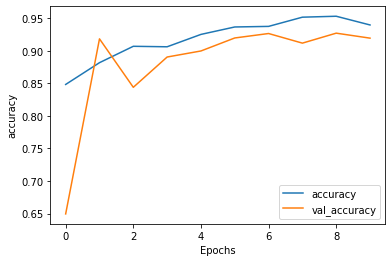

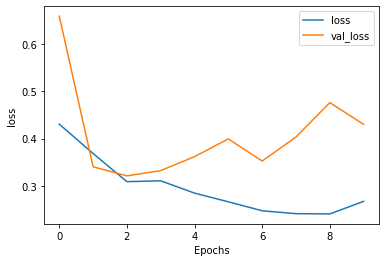

In [65]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

In [62]:
fechaHora = datetime.now().strftime("%Y%m%d-%H%M%S")
fechaHora
try:
    lstm3.save('rnn_' + fechaHora)
except:
    print("Genera una excepcion pero guarda el archivo")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rnn_20200918-233536\assets


#### Matriz de confusion y resultado final de accuracy de word2vec

In [73]:
y_pred=lstm3.predict_classes(X_test)

In [74]:
confusion_matrix(y_test,y_pred)

array([[1937,   89],
       [  92, 1539]], dtype=int64)

In [75]:
accuracy_score(y_test,y_pred)

0.9505058791359038

## Conclusiones

Para lograr un buen procesamiento de la parte textual es necesario contar con librerias y/o modelos que faciliten este proceso, que resultaria en un esfuerzo demasiado complejo para una persona individual o incluso organizaciones pequeñas

Constantemente sufren actualizaciones los modelos, por lo que es importante revisar continuamente las mejoras o nuevos modelos que resultan de esfuerzos mas grandes para lograr tener una base mas solida en la que se pueda trabajar y analizar la informacion